In [1]:
import numpy as np
from astropy import units as u
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
from astropy import wcs
from astropy.time import Time
import matplotlib.pylab as plt
%matplotlib inline

In [2]:
site = EarthLocation.of_site('Gemini South')

In [3]:
# let's make a list of stars
names = ['id', 'identifier', 'typ', 'coord1', 'Mag U', 'Mag B', 'Mag V', 'Mag R', 'Mag I']
types = [int, 'U20', 'U20', 'U100', float, float, float, float]
star_data = np.genfromtxt('stars.dat', delimiter='|', comments='#', dtype=list(zip(names, types)))

In [4]:
coord_list = []
for star in star_data:
    coord_str = star['coord1']
    coord_str = coord_str.replace('+', ',+').replace('-', ',-')
    coords_str = coord_str.split(',')
    coord_list.append(SkyCoord(ra=coords_str[0]+' hours', dec=coords_str[1]+' degrees'))
# Here's a list of stars that we can use
coords = SkyCoord(coord_list)

In [5]:
# While this says RA, DEC, we are going to treat it as an azimuth, altitude projection
w = wcs.WCS(naxis=2)

#crpix1=2.87356521e+03, crpix2=1.98559533e+03
# From previous all-sky fits
x0 = np.array([2.87356521e+03,   1.98559533e+03,  1., 1., .036,
        0.0027,  0.00295,   -0.0359])

w.wcs.crpix = [x0[0], x0[1]]
w.wcs.cdelt = [x0[2], x0[3]]
w.wcs.pc = x0[4:8].reshape((2, 2))
#w.wcs.set_pv([(2, 1, x0[8]), (2, 2, x0[9])])


#w.wcs.crpix = [500, 500]
#w.wcs.cdelt = np.array([-0.2, 0.2])
#w.wcs.crval = [0, 90]
w.wcs.ctype = ["RA---ZEA", "DEC--ZEA"]
#w.wcs.set_pv([(2, 1, 45.0)])

In [6]:
mjds = np.arange(0,3,1)/24. + 35623 
times = Time(mjds, format='mjd')

In [18]:
xs = []
ys = []
mjd_arr = []
for time in times:
    stars_altaz = coords.transform_to(AltAz(obstime=time, location=site))
    # Astropy is smart enough to ignore alt_az, so we have to trick it
    stars_psudo = SkyCoord(ra=stars_altaz.az, dec =stars_altaz.alt)
    x,y = w.world_to_pixel(stars_psudo)
    on_chip = np.where((x > 0) & (x < 4000) & (y > 0) & (y < 4000))[0]
    xs.append(x[on_chip])
    ys.append(y[on_chip])
    mjd_arr.append([time.mjd]*len(x[on_chip]))
xs = np.concatenate(xs)
ys = np.concatenate(ys)
mjd_arr = np.concatenate(mjd_arr)

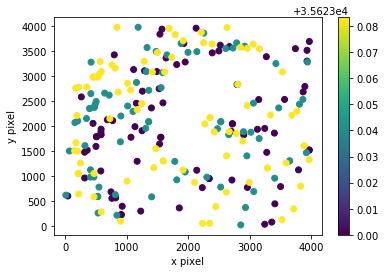

In [21]:
plt.scatter(xs, ys, c=mjd_arr)
plt.xlabel('x pixel')
plt.ylabel('y pixel')
cb = plt.colorbar()